<a href="https://colab.research.google.com/github/OmdenaAI/omdena-srilanka-tea-quality/blob/task-4-model-building/task_4_model_building/leaf-classifier-detector-torch/Tea_leaf_classifier_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tea Leaf classifier and detector

We're using `PyTorch` library for our classification and object detection tasks.

__Goal:__
- Given an image containing well-separated tea leaves on white background
- Classify if, the tea leaf is `Fresh` or `Withered`
- Detect each tea leaf in the image
- Classify the category of each tea leaf into one of these categories:
  - `Best`, or
  - `Below Best`, or
  - `Poor`
- Return the prediction with following structure:
  ```json
  {
    "type": "fresh",
    "categories":{
      "best":80.5,
      "below_best":14.5,
      "poor":5.0
    }
  }
  ```

## Import libraries

In [1]:
import zipfile
import os
import glob
from sklearn.model_selection import train_test_split
import pathlib
import shutil
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image



plt.ion()   # interactive mode

## Download the dataset

In [2]:
# !gdown --id 1UCGzcV5ZTC51ShC8hFrE2esC-MdlvRn- 
# !gdown --id 1bu048J7cfuNJpcIlJO2_KIg_tY3IX7p8

Downloading...
From: https://drive.google.com/uc?id=1UCGzcV5ZTC51ShC8hFrE2esC-MdlvRn-
To: /content/Fresh.zip
100% 172M/172M [00:01<00:00, 159MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bu048J7cfuNJpcIlJO2_KIg_tY3IX7p8
To: /content/Withered.zip
100% 230M/230M [00:01<00:00, 156MB/s]


In [3]:
# Make and change directory `data`
# !mkdir data

In [4]:
# local_zip = '/content/Fresh.zip'
# zip_ref = zipfile.ZipFile(local_zip,'r')
# zip_ref.extractall('/content/data')
# zip_ref.close()

# local_zip = '/content/Withered.zip'
# zip_ref = zipfile.ZipFile(local_zip,'r')
# zip_ref.extractall('/content/data')
# zip_ref.close()

In [5]:
data_dir = '/content/data'

In [6]:
def display_image_files_len(root_folder, folder_name=''):
  types = ['Fresh', 'Withered']
  categories = ['Below Best', 'Best', 'Poor']
  for type_ in types:
    for category in categories:
      print(folder_name, type_, category, len(os.listdir(os.path.join(root_folder, folder_name, type_, category))))

In [7]:
display_image_files_len(data_dir)

 Fresh Below Best 73
 Fresh Best 153
 Fresh Poor 43
 Withered Below Best 279
 Withered Best 269
 Withered Poor 273


In [8]:
image_list = np.array(glob.glob(data_dir + '/*/*/*.jpg'))
print(f'Total image files are: {len(image_list)}')
print(image_list[:5])

Total image files are: 1090
['/content/data/Fresh/Poor/Low_Fresh_Poor (33).jpg'
 '/content/data/Fresh/Poor/Low_Fresh_Poor (32).jpg'
 '/content/data/Fresh/Poor/Low_Fresh_Poor (25).jpg'
 '/content/data/Fresh/Poor/Low_Fresh_Poor (24).jpg'
 '/content/data/Fresh/Poor/Low_Fresh_Poor (30).jpg']


In [9]:
train_set, test_set = train_test_split(image_list, test_size=0.1, random_state=42)
train_set, val_set = train_test_split(train_set, test_size=0.11, random_state=42)

print(len(train_set), len(val_set), len(test_set))

873 108 109


In [10]:
final_data_dir = '/content/final_data'

In [11]:
def get_image_label(img_path):
  '''
  Extract image label from the img_path.

  Assumption:
    img_path is of the form: /content/data/Fresh/Poor/*.jpg

  Arguments:
    img_path: Path of the image file
  Returns:
    str: image label
  '''
  parts = img_path.split('/')
  label_parts = parts[-3:-1]
  return '_'.join(label_parts)

In [12]:
get_image_label('/content/data/Fresh/Poor/Low_Fresh_Poor (33).jpg')

'Fresh_Poor'

In [13]:
def copy_files(output_dir, folder_type, image_list):
  path = os.path.join(output_dir, folder_type)
  pathlib.Path(path).mkdir(parents=True, exist_ok=True)
  for file_path in image_list:
    dst_path = os.path.join(path, get_image_label(file_path))
    pathlib.Path(dst_path).mkdir(exist_ok=True)
    shutil.copy2(file_path, dst_path)

In [14]:
copy_files(final_data_dir, 'train', train_set)
copy_files(final_data_dir, 'val', val_set)
copy_files(final_data_dir, 'test', test_set)

## Prepare the dataset

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),                                       
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
loader_shuffle = {
    'train': True,
    'val': False,
    'test': False,
}

batch_size = 4
num_workers = 2
phases = ['train', 'val', 'test']

image_datasets = {x: datasets.ImageFolder(os.path.join(final_data_dir, x),
                                          data_transforms[x])
                  for x in phases}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=loader_shuffle[x],
                                              num_workers=num_workers)
              for x in phases}
dataset_sizes = {x: len(image_datasets[x]) for x in phases}
class_names = image_datasets['train'].classes
print(class_names)

print("Number of avaialable classes: " , len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Fresh_Below Best', 'Fresh_Best', 'Fresh_Poor', 'Withered_Below Best', 'Withered_Best', 'Withered_Poor']
Number of avaialable classes:  6


In [19]:
print(dataset_sizes)

{'train': 873, 'val': 108, 'test': 109}


In [26]:
print(device)

cuda:0


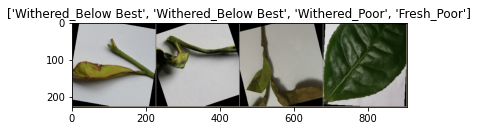

In [20]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model Training

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetune the convnet

In [27]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

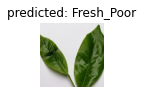

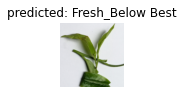

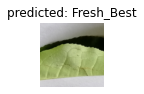

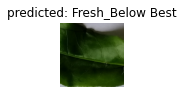

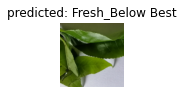

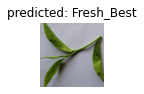

In [29]:
visualize_model(model_ft)

## Save the model

In [30]:
torch.save(model_ft, 'model_resnet.pth')

# Inference using model

In [31]:
model = torch.load('model_resnet.pth')

tensor([0, 0, 0, 0], device='cuda:0')
Fresh_Below Best


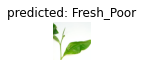

Fresh_Below Best


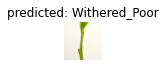

Fresh_Below Best


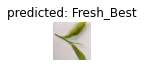

Fresh_Below Best


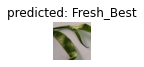

tensor([0, 0, 0, 0], device='cuda:0')
Fresh_Below Best


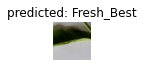

Fresh_Below Best


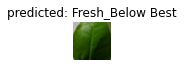

Fresh_Below Best


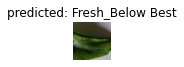

Fresh_Below Best


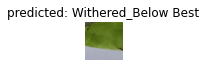

tensor([0, 1, 1, 1], device='cuda:0')
Fresh_Below Best


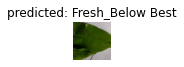

Fresh_Best


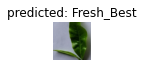

In [38]:
num_images = 10
model.eval()
images_so_far = 0
fig = plt.figure()
exit = False

for i, (inputs, labels) in enumerate(dataloaders['test']):
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = model(inputs)
  _, preds = torch.max(outputs, 1)
  print(labels)

  for j in range(inputs.size()[0]):
      print(class_names[labels[j]])
      images_so_far += 1
      ax = plt.subplot(num_images//2, 2, images_so_far)
      ax.axis('off')
      ax.set_title('predicted: {}'.format(class_names[preds[j]]))
      imshow(inputs.cpu().data[j])

      if images_so_far == num_images:
        exit = True
        break
  if exit:
    break